# Code efficiency

This exercise explores some tools that can be used to measure code execution time and to calculate the CO<sub>2</sub>-equivalent emissions that are generated. The two quantities are closely correlated, but other factors such as the carbon intensity of the local energy supply can affect the final calculations.

## Execution timing

Python is the most popular language for many resource-intensive activities such as machine learning and data science. Because the datasets used in those areas are so large, processing takes a lot of time and a lot of resources. Being able to measure execution time is the first step on the way to identifying bottlenecks and making improvements.

Python provides a built-in package called [`timeit`](https://docs.python.org/3/library/timeit.html) for timing code execution. It can be run in a few different ways; we will be using the `timeit` convenience function which takes three important parameters:

``` python
timeit.timeit(stmt='pass', setup='pass', number=1000000)
```

* `stmt` is the code to be timed
* `setup` is where import statements and other initialisation code can be defined. These statements are not included in the timing
* `number` is the number of times that `stmt` should be run. The result is divided by the same number to give the average time for a single execution

The following code creates a list of 10000 random integers using the [`random`](https://docs.python.org/3/library/random.html) package. It runs 10000 times and displays the average time for one execution in seconds.

In [156]:
import timeit

t1 = timeit.timeit(stmt='[random.randint(0, 1000) for r in range(10000)]', 
              setup='import random', 
              number=1000
             )
print('Creating a list of 10000 random integers takes {:.4f}s on average'.format(t1/1000))

Creating a list of 10000 random integers takes 0.0079s on average


We can use `timeit` to examine the execution time of different sorting algorithms. The code below creates a list of random integers as before, but this time we will pass it into the `timeit` function in the `setup` parameter. This allows us to compare different sorting algorithms directy since they are being applied to the same object. Here, we compare the *MergeSort* and *BubbleSort* implementations from a package called [`pysort`](https://github.com/srimani-programmer/pysort). To reduce the waiting time, we only run each algorithm 20 times.

In [157]:
import random
from sorting_techniques import pysort

list_size = 2500
numbers = [random.randint(0, 1000) for r in range(list_size)]
repeats = 20
sortObj = pysort.Sorting()

t1 = timeit.timeit(stmt='sortResult = sortObj.bubbleSort(numbers)', 
              setup='from __main__ import sortObj, numbers', 
              number=repeats
             )
print('BubbleSort: {:.4f}s'.format(t1/repeats))
t2 = timeit.timeit(stmt='sortResult = sortObj.mergeSort(numbers)', 
              setup='from __main__ import sortObj, numbers', 
              number=repeats
             )

print('MergeSort: {:.4f}s'.format(t2/repeats))

BubbleSort: 0.3069s
MergeSort: 0.0070s


From the results, it is clear that the choice of algorithm has a significant effect on the execution time and hence on carbon emissions. This raises a couple of questions:

* Which sorting algorithm is the fastest?
* How does the default `sorted()` function perform in comparison to other sorting algorithms?

The default python sorting function uses an algoritm called [TimSort](https://en.wikipedia.org/wiki/Timsort). The code below runs it on the same list of random integers as before, and also does the same with all of the sorting algorithms implemented in `pySort`. To make it easier to plot the results they are collected into a [pandas](https://pandas.pydata.org/) Series object.

(Note that QuickSort may fail if the list is too large because it exceeds the maximum allowed number of recursions)

In [158]:
import pandas as pd

numbers = [random.randint(0, 1000) for r in range(list_size)]

algorithms = ['sorted', 'quickSort', 'bubbleSort', 'selectionSort', 'insertionSort', 'shellSort', 'pigeonHoleSort', 'heapSort', 'gnomeSort', 'pancakeSort', 'bogoSort', 'mergeSort', 'cocktailSort', 'brickSort', 'radixSort']
trials = pd.Series(index=algorithms, dtype=float)

for algorithm in algorithms:
    if algorithm == 'sorted':
        t1 = timeit.timeit(stmt='sortResult = sorted(numbers)', 
                      setup='from __main__ import numbers', 
                      number=repeats
                     )
    elif algorithm == 'quickSort':
        try:
            t1 = timeit.timeit(stmt='sortResult = quickSort(numbers, 0, len(numbers)-1)', 
                          setup='from __main__ import sortObj, numbers', 
                          number=repeats
                         )
        except:
            pass
    else:
        method = None
        try:
            method = getattr(sortObj, algorithm)
        except AttributeError:
            raise NotImplementedError("Class `{}` does not implement `{}`".format(my_cls.__class__.__name__, method_name))
        t1 = timeit.timeit(stmt='sortResult = method(numbers)', 
                      setup='from __main__ import method, numbers', 
                      number=repeats
                     )
        
    trials[algorithm] = t1/repeats


With the results now in, we can compare them on a bar chart. If you need to zoom in to see some of the smaller values, just adjust the `limit` value to eliminate values above a threshold and run the plot again.

Text(0, 0.5, 'Execution time (s)')

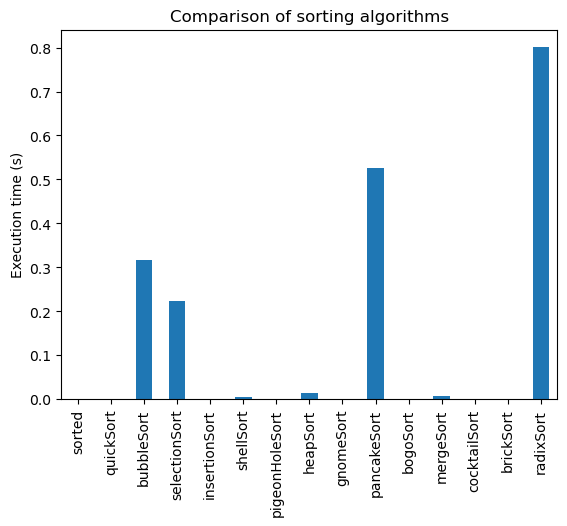

In [160]:
limit = 1
ax = trials[trials < limit].plot.bar()
ax.set_title("Comparison of sorting algorithms")
ax.set_ylabel("Execution time (s)")

We can also check the complexity of a sorting algorithm against its theoretical performance. The thoeretical complexity of bubbleSort, for example, is O(n<sup>2</sup>). We can check this by running the algorithm several times for arrays of different lengths and plotting the actual performance against expected. Remember that the Big O expression represents the worst case.

Text(0, 0.5, 'Execution time (s)')

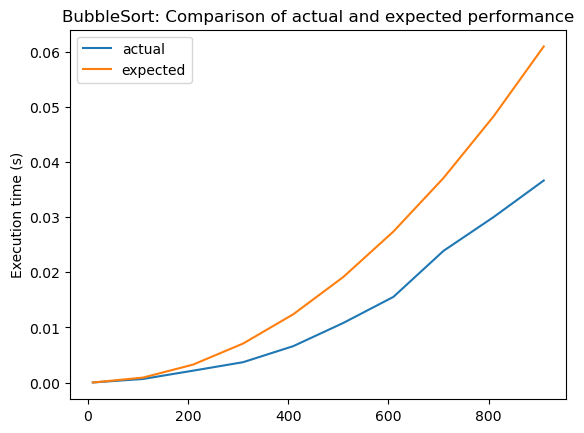

In [161]:
import math

df = pd.DataFrame(index=[n for n in range(10, 1000, 100)], columns=['actual', 'expected'])
repeats = 20
factor = 1

for n in range(10, 1000, 100):
    numbers = [random.randint(0, 1000) for r in range(n)]
    t1 = timeit.timeit(stmt='sortResult = sortObj.bubbleSort(numbers)', 
                       setup='from __main__ import sortObj, numbers', 
                       number=repeats
                      )
    actual = t1 / repeats
    expected = n**2
    if n == 10:
        factor = expected / actual
    df.loc[n] = [actual, expected/factor]

ax = df.plot()
ax.set_title("BubbleSort: Comparison of actual and expected performance")
ax.set_ylabel("Execution time (s)")

## Emissions

Execution time correlates closely with emissions, but there are a few contextual parameters that may also be important. For example, the carbon intensity of the local energy supply will have a major impact on the results.

The python package [CodeCarbon](https://codecarbon.io/) combines execution time with the local energy environment and also includes factors representing the cloud provider if applicable. CodeCarbon reports its results in kg CO<sub>2</sub>-eq

As an example, we can use CodeCarbon to calculate the emissions generated as a result of performing the seach algorithm comparison from earlier.

In [ ]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker()
tracker.start()

numbers = [random.randint(0, 1000) for r in range(list_size)]

algorithms = ['sorted', 'quickSort', 'bubbleSort', 'selectionSort', 'insertionSort', 'shellSort', 'pigeonHoleSort', 'heapSort', 'gnomeSort', 'pancakeSort', 'bogoSort', 'mergeSort', 'cocktailSort', 'brickSort', 'radixSort']
trials = pd.Series(index=algorithms, dtype=float)

for algorithm in algorithms:
    if algorithm == 'sorted':
        t1 = timeit.timeit(stmt='sortResult = sorted(numbers)', 
                      setup='from __main__ import numbers', 
                      number=repeats
                     )
    elif algorithm == 'quickSort':
        try:
            t1 = timeit.timeit(stmt='sortResult = quickSort(numbers, 0, len(numbers)-1)', 
                          setup='from __main__ import sortObj, numbers', 
                          number=repeats
                         )
        except:
            pass
    else:
        method = None
        try:
            method = getattr(sortObj, algorithm)
        except AttributeError:
            raise NotImplementedError("Class `{}` does not implement `{}`".format(my_cls.__class__.__name__, method_name))
        t1 = timeit.timeit(stmt='sortResult = method(numbers)', 
                      setup='from __main__ import method, numbers', 
                      number=repeats
                     )
        
    trials[algorithm] = t1/repeats

emissions = tracker.stop()

print("Emissions: {:.4f}kg CO2-eq ({:.4f}g CO2-eq)".format(emissions, emissions*1000))

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.


Emissions: 0.0002kg CO2-eq (0.1797g CO2-eq)
